<a href="https://colab.research.google.com/github/1HPz/ChiangMaiRainForecast/blob/main/Predict_Rain_Level_By_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Rain_Volume_in_Chiangmai.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ปี-เดือน,ปริมาณน้ำฝน
0,2556-01,0.81
1,2556-02,1.13
2,2556-03,0.55
3,2556-04,0.04
4,2556-05,2.90


# **Check Stationarity**

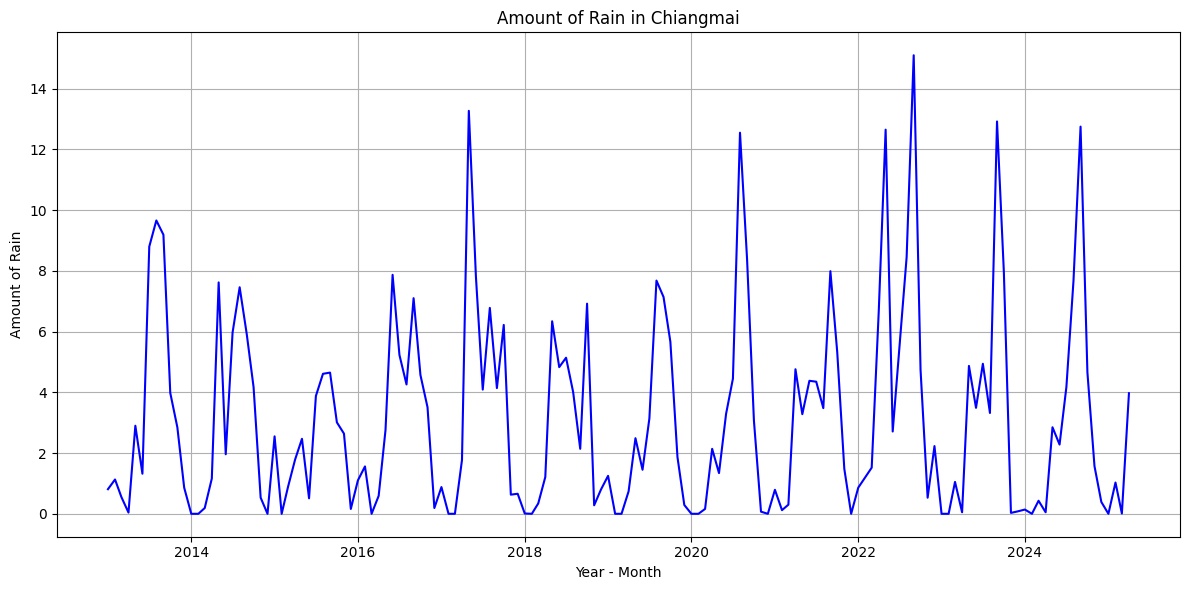

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Buddhist Era (BE) to Common Era (CE)
df['ปี-เดือน'] = df['ปี-เดือน'].apply(lambda x: str(int(x[:4]) - 543) + x[4:])

# Convert the data to datetime object
df['ปี-เดือน'] = pd.to_datetime(df['ปี-เดือน'], format='%Y-%m', errors='coerce')

# # Convert rainfall values to numeric type
df['ปริมาณน้ำฝน'] = pd.to_numeric(df['ปริมาณน้ำฝน'], errors='coerce')

# Drop rows with conversion errors or invalid values
df = df.dropna(subset=['ปี-เดือน', 'ปริมาณน้ำฝน'])

# Visualize the data to observe its trend and characteristics
plt.figure(figsize=(12, 6))
plt.plot(df['ปี-เดือน'], df['ปริมาณน้ำฝน'], linestyle='-', color='blue')
plt.xlabel('Year - Month')
plt.ylabel('Amount of Rain')
plt.title('Amount of Rain in Chiangmai')
plt.grid(True)
plt.tight_layout()
plt.show()


**ADF test**

In [ ]:
# Check for stationarity of the time series
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['ปริมาณน้ำฝน'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.285277736399023
p-value: 0.17676016591404803


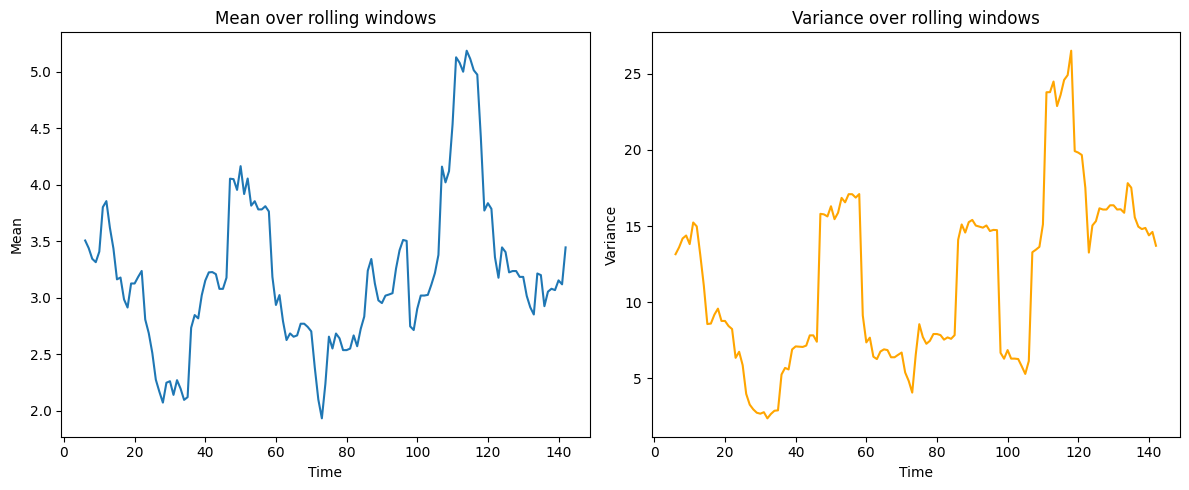

In [ ]:
# Test whether the time series is stationary (constant mean and variance over time)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df.index is datetime and 'value' is the target column (change if needed)
series = df['ปริมาณน้ำฝน']

# Set the window size in months, e.g., 12 months (1 year)
window_size = 12

# Create lists to store the mean and variance for each window
means = []
variances = []
window_centers = []

for start in range(len(series) - window_size + 1):
    window = series.iloc[start:start + window_size]
    means.append(window.mean())
    variances.append(window.var())
    window_centers.append(window.index[window_size // 2])  # เก็บตำแหน่งกลาง window

# Convert to Series for plotting
means = pd.Series(means, index=window_centers)
variances = pd.Series(variances, index=window_centers)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(means, marker='')
plt.title('Mean over rolling windows')
plt.xlabel('Time')
plt.ylabel('Mean')

plt.subplot(1,2,2)
plt.plot(variances, marker='', color='orange')
plt.title('Variance over rolling windows')
plt.xlabel('Time')
plt.ylabel('Variance')

plt.tight_layout()
plt.show()


**Transforming to Stationary**

In [ ]:
# Perform differencing to remove trends and achieve stationarity
df['y_diff1'] = df['ปริมาณน้ำฝน'] - df['ปริมาณน้ำฝน'].shift(1)  # First order differencing

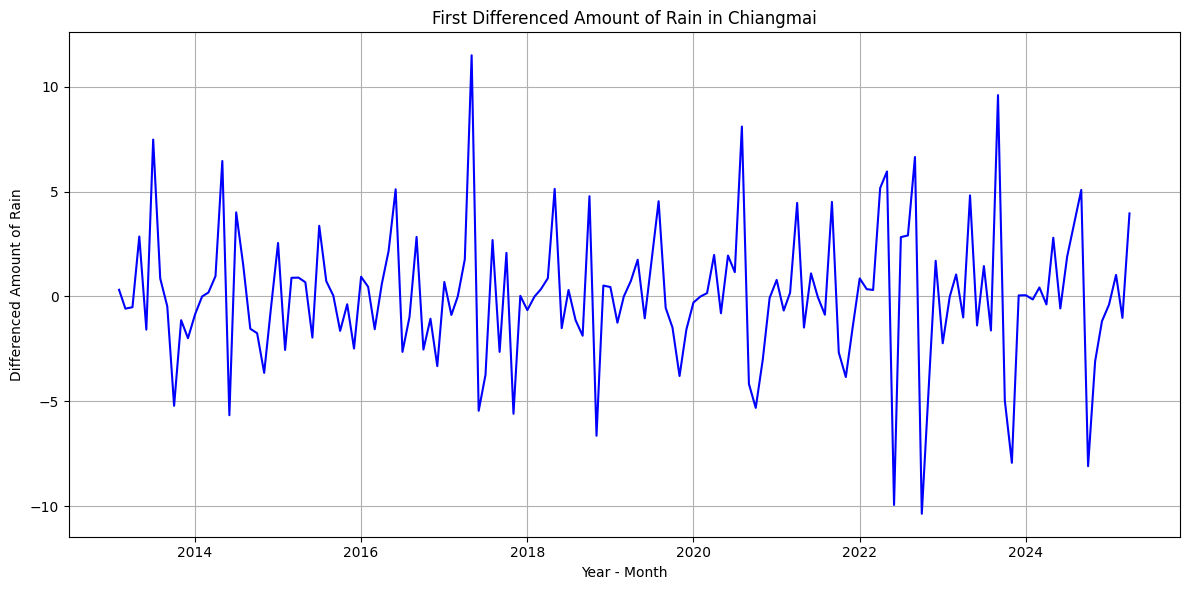

In [ ]:
import matplotlib.pyplot as plt

# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(df['ปี-เดือน'], df['y_diff1'], linestyle='-', color='blue')
plt.xlabel('Year - Month')
plt.ylabel('Differenced Amount of Rain')
plt.title('First Differenced Amount of Rain in Chiangmai')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Check if the data is stationary after differencing
result_diff = adfuller(df['y_diff1'].dropna())
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])

# ตีความ p-value
alpha = 0.05
if result_diff[1] <= alpha:
    print("p-value <= alpha (", alpha, "): Reject the null hypothesis (H0). The data is stationary.")
else:
    print("p-value > alpha (", alpha, "): Fail to reject the null hypothesis (H0). The data is non-stationary.")

ADF Statistic (Differenced): -12.088999431240106
p-value (Differenced): 2.1442534580916813e-22
p-value <= alpha ( 0.05 ): Reject the null hypothesis (H0). The data is stationary.


**Analyze ACF and PACF to Choose Lag Parameters**

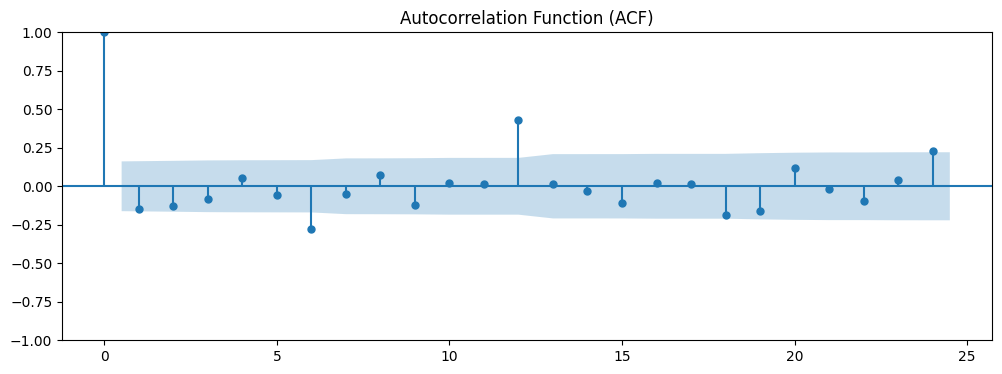

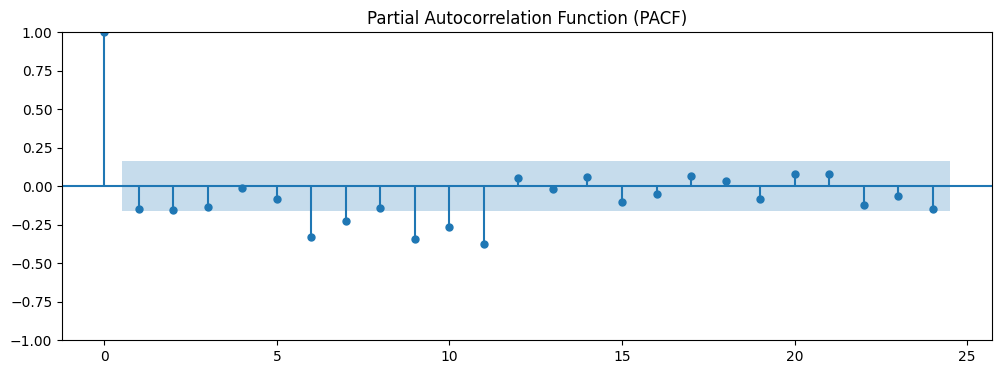

In [ ]:
# Calculate ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

stationary_series = df['y_diff1'].dropna()

# Plot ACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(stationary_series, ax=ax, lags=24) # You can adjust the number of lags
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(stationary_series, ax=ax, lags=24) # You can adjust the number of lags
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**Test-Train spilt**

In [ ]:
# Divide dataset into training (70%), validation (20%), and testing (10%) subsets
n = len(df)
train_size = int(n * 0.7)
val_size = int(n * 0.2)
test_size = n - train_size - val_size

train = df.iloc[:train_size]
validation = df.iloc[train_size:train_size + val_size]
test = df.iloc[train_size + val_size:]

# **SARIMA Model**

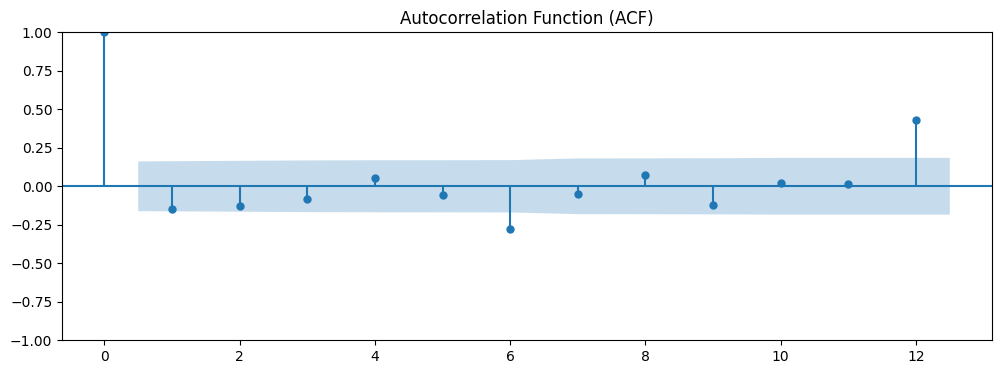

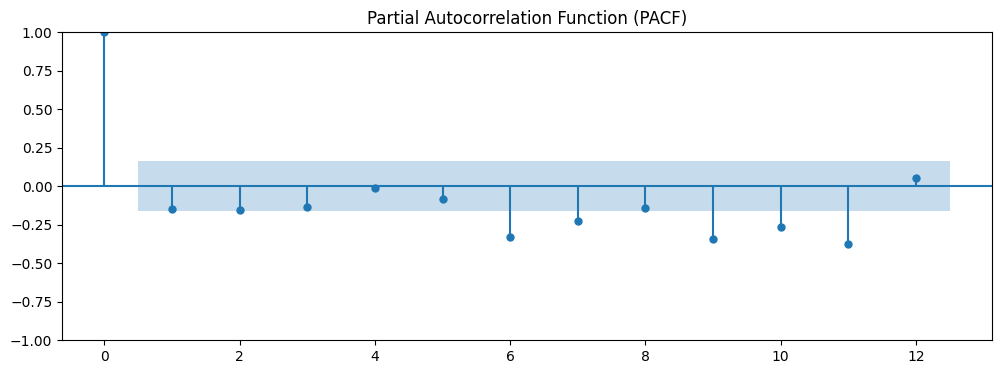

In [ ]:
# Calculate ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

stationary_series = df['y_diff1'].dropna()

# Plot ACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(stationary_series, ax=ax, lags=12) # You can adjust the number of lags
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(stationary_series, ax=ax, lags=12) # You can adjust the number of lags
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
# Divide dataset into training (70%), validation (20%), and testing (10%) subsets
n = len(df)
train_size = int(n * 0.7)
val_size = int(n * 0.2)
test_size = n - train_size - val_size

train = df.iloc[:train_size]
validation = df.iloc[train_size:train_size + val_size]
test = df.iloc[train_size + val_size:]

In [ ]:
# Search for the optimal parameters to build the SARIMA model
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Check what is the best parameter for SARIMA
# Suppress warnings during model fitting
warnings.filterwarnings("ignore")

# Parameters set according to the given specifications
p_values = [6, 7, 9, 10, 11]
d = 1
q_values = [6, 12]
P = 0
D = 1
Q = 1
s = 12

# To store the output/results
results = []
best_aic = float("inf")
best_params = None

# Iterate over all possible combinations of (p, q) parameters
for p, q in itertools.product(p_values, q_values):
    try:
        model = SARIMAX(
            train['y_diff1'].dropna(),
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        aic = model_fit.aic

        results.append(((p, d, q), (P, D, Q, s), aic))

        if aic < best_aic:
            best_aic = aic
            best_params = ((p, d, q), (P, D, Q, s))

        print(f"Tested ARIMA{(p, d, q)} x {(P, D, Q, s)} - AIC: {aic:.2f}")

    except Exception as e:
        print(f"Model failed for ARIMA{(p, d, q)} - {e}")

# Output the best-performing parameters
print("\nBest model parameters:")
print(f"Order: {best_params[0]}, Seasonal Order: {best_params[1]}, AIC: {best_aic:.2f}")


Tested ARIMA(6, 1, 6) x (0, 1, 1, 12) - AIC: 334.77
Model failed for ARIMA(6, 1, 12) - Invalid model: moving average lag(s) {12} are in both the seasonal and non-seasonal moving average components.
Tested ARIMA(7, 1, 6) x (0, 1, 1, 12) - AIC: 337.29
Model failed for ARIMA(7, 1, 12) - Invalid model: moving average lag(s) {12} are in both the seasonal and non-seasonal moving average components.
Tested ARIMA(9, 1, 6) x (0, 1, 1, 12) - AIC: 340.30
Model failed for ARIMA(9, 1, 12) - Invalid model: moving average lag(s) {12} are in both the seasonal and non-seasonal moving average components.
Tested ARIMA(10, 1, 6) x (0, 1, 1, 12) - AIC: 330.80
Model failed for ARIMA(10, 1, 12) - Invalid model: moving average lag(s) {12} are in both the seasonal and non-seasonal moving average components.
Tested ARIMA(11, 1, 6) x (0, 1, 1, 12) - AIC: 410.91
Model failed for ARIMA(11, 1, 12) - Invalid model: moving average lag(s) {12} are in both the seasonal and non-seasonal moving average components.

Best 

In [ ]:
# Run the SARIMA model with the optimal parameters
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_x = SARIMAX(
    train['y_diff1'].dropna(),
    order=(10, 1, 6),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_x_fit = model_x.fit(disp=False)
print(model_x_fit.summary())

                                       SARIMAX Results                                       
Dep. Variable:                               y_diff1   No. Observations:                  102
Model:             SARIMAX(10, 1, 6)x(0, 1, [1], 12)   Log Likelihood                -147.402
Date:                               Thu, 24 Jul 2025   AIC                            330.803
Time:                                       09:05:43   BIC                            371.276
Sample:                                            0   HQIC                           346.880
                                               - 102                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8875      0.423     -2.097      0.036      -1.717      -0.058
ar.L2      

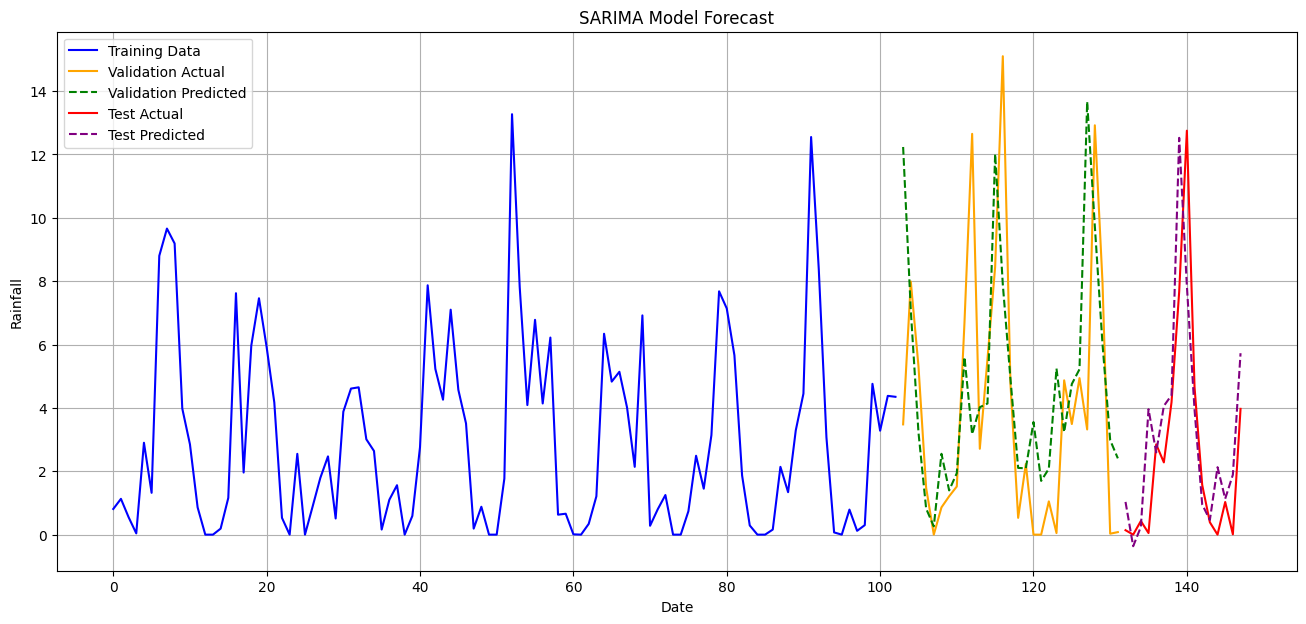

Validation RMSE: 3.85
Validation MAE: 2.63
Test RMSE: 2.22
Test MAE: 1.54


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Forecast validation set using the fitted model
# Determine prediction start and end relative to training data
# Get index from training data used in model fitting
train_diff_index = train['y_diff1'].dropna().index

# Find validation start position aligned with training data index
try:
   # Find start position of validation within training data for prediction
    start_loc_val = train_diff_index.get_loc(validation.index[0])
except KeyError:
    # If validation start not in training index, use training data length as start
    start_loc_val = len(train_diff_index)

# Set end position = start position + validation length - 1
end_loc_val = start_loc_val + len(validation) - 1


# Predict on differenced series for validation set
val_pred_diff = model_x_fit.predict(start=start_loc_val, end=end_loc_val, dynamic=False)

# Align differenced forecast index with validation index
val_pred_diff.index = validation.index


# Inverse differencing to get original scale for validation predictions
val_pred = []
# Use last training value to start inverse differencing for validation
last_train_y = train['ปริมาณน้ำฝน'].iloc[-1] # Use the correct column name

# First validation prediction = last training value + first differenced prediction
if len(val_pred_diff) > 0:
    val_pred.append(last_train_y + val_pred_diff.iloc[0])
    # Iterate over remaining differenced validation predictions
    for i in range(1, len(val_pred_diff)):
        next_prediction = val_pred[-1] + val_pred_diff.iloc[i]
        val_pred.append(next_prediction)

# Convert validation predictions list to Series with proper index
val_pred = pd.Series(val_pred, index=validation.index)


# Forecast test set
# Find start and end positions for test prediction relative to training dat
# Test start position = validation end position + 1
start_loc_test = end_loc_val + 1

# Set test end position = start position + test length - 1
end_loc_test = start_loc_test + len(test) - 1


# Make predictions on the differenced series for the test set
test_pred_diff = model_x_fit.predict(start=start_loc_test, end=end_loc_test, dynamic=False)

# Predict on differenced series for test set
test_pred_diff.index = test.index

# Inverse differencing to restore original scale for test predictions
test_pred = []
# Use last validation value to start inverse differencing for test
last_val_y = validation['ปริมาณน้ำฝน'].iloc[-1]

# First test prediction = last validation value + first differenced prediction
if len(test_pred_diff) > 0:
    test_pred.append(last_val_y + test_pred_diff.iloc[0])
    # Iterate over remaining differenced test predictions
    for i in range(1, len(test_pred_diff)):
        next_prediction = test_pred[-1] + test_pred_diff.iloc[i]
        test_pred.append(next_prediction)

# Convert test predictions list to Series with proper index
test_pred = pd.Series(test_pred, index=test.index)


# Plot results
plt.figure(figsize=(16, 7))
plt.plot(train.index, train['ปริมาณน้ำฝน'], label='Training Data', color='blue')
plt.plot(validation.index, validation['ปริมาณน้ำฝน'], label='Validation Actual', color='orange')
plt.plot(validation.index, val_pred, label='Validation Predicted', color='green', linestyle='--')
plt.plot(test.index, test['ปริมาณน้ำฝน'], label='Test Actual', color='red')
plt.plot(test.index, test_pred, label='Test Predicted', color='purple', linestyle='--')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate results
# Validation set
# Ensure no NaNs in actual or predicted values before calculating metrics
actual_val_cleaned = validation['ปริมาณน้ำฝน'].dropna()
val_pred_cleaned = val_pred.dropna()
common_index_val = actual_val_cleaned.index.intersection(val_pred_cleaned.index)
actual_val_aligned = actual_val_cleaned.loc[common_index_val]
val_pred_aligned = val_pred_cleaned.loc[common_index_val]

if not common_index_val.empty:
    rmse_val = sqrt(mean_squared_error(actual_val_aligned, val_pred_aligned))
    mae_val = mean_absolute_error(actual_val_aligned, val_pred_aligned)
    print(f'Validation RMSE: {rmse_val:.2f}')
    print(f'Validation MAE: {mae_val:.2f}')
else:
     print("No common time points between actual and forecasted data for validation evaluation.")

# Test set
actual_test_cleaned = test['ปริมาณน้ำฝน'].dropna()
test_pred_cleaned = test_pred.dropna()
common_index_test = actual_test_cleaned.index.intersection(test_pred_cleaned.index)
actual_test_aligned = actual_test_cleaned.loc[common_index_test]
test_pred_aligned = test_pred_cleaned.loc[common_index_test]

if not common_index_test.empty:
    rmse_test = sqrt(mean_squared_error(actual_test_aligned, test_pred_aligned))
    mae_test = mean_absolute_error(actual_test_aligned, test_pred_aligned)
    print(f'Test RMSE: {rmse_test:.2f}')
    print(f'Test MAE: {mae_test:.2f}')
else:
    print("No common time points between actual and forecasted data for test evaluation.")

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

# --- Evaluate Validation Set (SMAPE) ---
actual_val_cleaned = validation['ปริมาณน้ำฝน'].dropna()
val_pred_cleaned = val_pred.dropna()

common_index_val = actual_val_cleaned.index.intersection(val_pred_cleaned.index)

actual_val_aligned = actual_val_cleaned.loc[common_index_val]
val_pred_aligned = val_pred_cleaned.loc[common_index_val]

if not common_index_val.empty:
    # Calculate SMAPE for Validation set
    # Avoid division by zero or very small numbers in SMAPE calculation
    smape_val = np.mean(2 * np.abs(val_pred_aligned - actual_val_aligned) / (np.abs(actual_val_aligned) + np.abs(val_pred_aligned) + 1e-8)) * 100
    print(f'Validation SMAPE (Inverse Differenced): {smape_val:.2f}%')
else:
    print("No common time points between actual and forecasted data for validation evaluation.")


# --- Evaluate Test Set (SMAPE) ---
actual_test_cleaned = test['ปริมาณน้ำฝน'].dropna()
test_pred_cleaned = test_pred.dropna()

common_index_test = actual_test_cleaned.index.intersection(test_pred_cleaned.index)

actual_test_aligned = actual_test_cleaned.loc[common_index_test]
test_pred_aligned = test_pred_cleaned.loc[common_index_test]

if not common_index_test.empty:
    # Calculate SMAPE for Test set
    # Avoid division by zero or very small numbers in SMAPE calculation
    smape_test = np.mean(2 * np.abs(test_pred_aligned - actual_test_aligned) / (np.abs(actual_test_aligned) + np.abs(test_pred_aligned) + 1e-8)) * 100
    print(f'Test SMAPE (Inverse Differenced): {smape_test:.2f}%')
else:
    print("No common time points between actual and forecasted data for test evaluation.")

Validation SMAPE (Inverse Differenced): 79.28%
Test SMAPE (Inverse Differenced): 80.96%


# SARIMA 2

**Analyze ACF and PACF to Choose Lag Parameters**

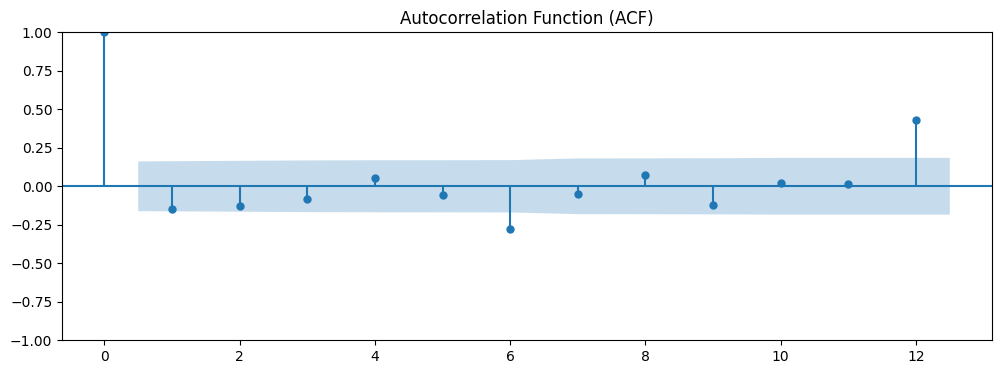

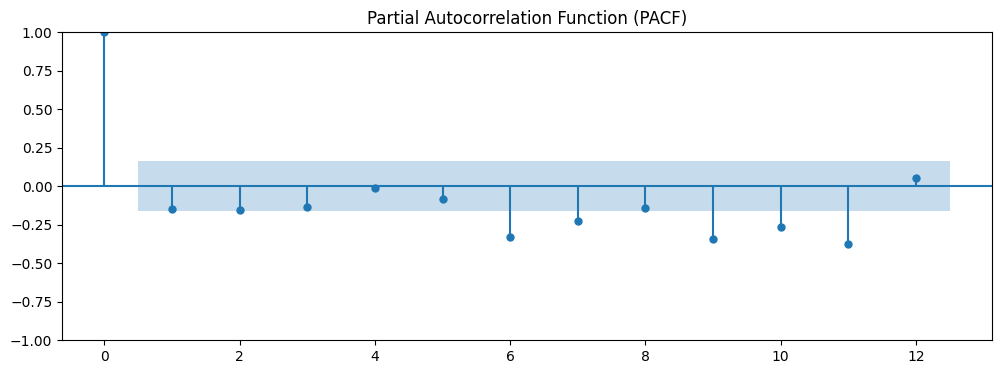

In [ ]:
# Calculate ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function)
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

stationary_series = df['y_diff1'].dropna()

# Plot ACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(stationary_series, ax=ax, lags=12) # You can adjust the number of lags
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(stationary_series, ax=ax, lags=12) # You can adjust the number of lags
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**Test-Train spilt**

In [ ]:
# Divide dataset into training (90%) and testing (10%) subsets
n = len(df)
train_size = int(n * 0.9)
test_size = n - train_size

train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(f"Dataset size: {n}")
print(f"Training size: {len(train)} ({len(train)/n*100:.1f}%)")
print(f"Testing size: {len(test)} ({len(test)/n*100:.1f}%)")

Dataset size: 148
Training size: 133 (89.9%)
Testing size: 15 (10.1%)


**Deploy SARIMA Model**

In [ ]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings during model fitting
warnings.filterwarnings("ignore")

# Parameters set according to the given specifications
p_values = [6, 7, 9, 10, 11]
d = 0
q_values = [6, 12]
P = 0
D = 1
Q = 1
s = 12

# To store the output/results
results = []
best_aic = float("inf")
best_params = None

# Iterate over all possible combinations of (p, q) parameters
for p, q in itertools.product(p_values, q_values):
    # Skip combinations where q == s * Q (conflicting MA lags)
    if q == s * Q:
        print(f"Skipping ARIMA({p}, {d}, {q}) x ({P}, {D}, {Q}, {s}) due to MA lag conflict")
        continue

    try:
        model = SARIMAX(
            train['y_diff1'].dropna(),
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        aic = model_fit.aic

        results.append(((p, d, q), (P, D, Q, s), aic))

        if aic < best_aic:
            best_aic = aic
            best_params = ((p, d, q), (P, D, Q, s))

        print(f"Tested ARIMA({p}, {d}, {q}) x ({P}, {D}, {Q}, {s}) - AIC: {aic:.2f}")

    except Exception as e:
        print(f"Model failed for ARIMA({p}, {d}, {q}) - {e}")

# Output the best-performing parameters
print("\nBest model parameters:")
print(f"Order: {best_params[0]}, Seasonal Order: {best_params[1]}, AIC: {best_aic:.2f}")


Tested ARIMA(6, 0, 6) x (0, 1, 1, 12) - AIC: 489.68
Skipping ARIMA(6, 0, 12) x (0, 1, 1, 12) due to MA lag conflict
Tested ARIMA(7, 0, 6) x (0, 1, 1, 12) - AIC: 489.20
Skipping ARIMA(7, 0, 12) x (0, 1, 1, 12) due to MA lag conflict
Tested ARIMA(9, 0, 6) x (0, 1, 1, 12) - AIC: 496.21
Skipping ARIMA(9, 0, 12) x (0, 1, 1, 12) due to MA lag conflict
Tested ARIMA(10, 0, 6) x (0, 1, 1, 12) - AIC: 498.83
Skipping ARIMA(10, 0, 12) x (0, 1, 1, 12) due to MA lag conflict
Tested ARIMA(11, 0, 6) x (0, 1, 1, 12) - AIC: 597.85
Skipping ARIMA(11, 0, 12) x (0, 1, 1, 12) due to MA lag conflict

Best model parameters:
Order: (7, 0, 6), Seasonal Order: (0, 1, 1, 12), AIC: 489.20


In [ ]:
# Run the SARIMA model with the optimal parameters
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_x = SARIMAX(
    train['y_diff1'].dropna(),
    order=(7, 0, 6),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_x_fit = model_x.fit(disp=False)
print(model_x_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              y_diff1   No. Observations:                  132
Model:             SARIMAX(7, 0, 6)x(0, 1, [1], 12)   Log Likelihood                -229.601
Date:                              Thu, 24 Jul 2025   AIC                            489.203
Time:                                      09:22:23   BIC                            528.430
Sample:                                           0   HQIC                           505.083
                                              - 132                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1945      0.405     -0.480      0.631      -0.989       0.600
ar.L2         -0.54

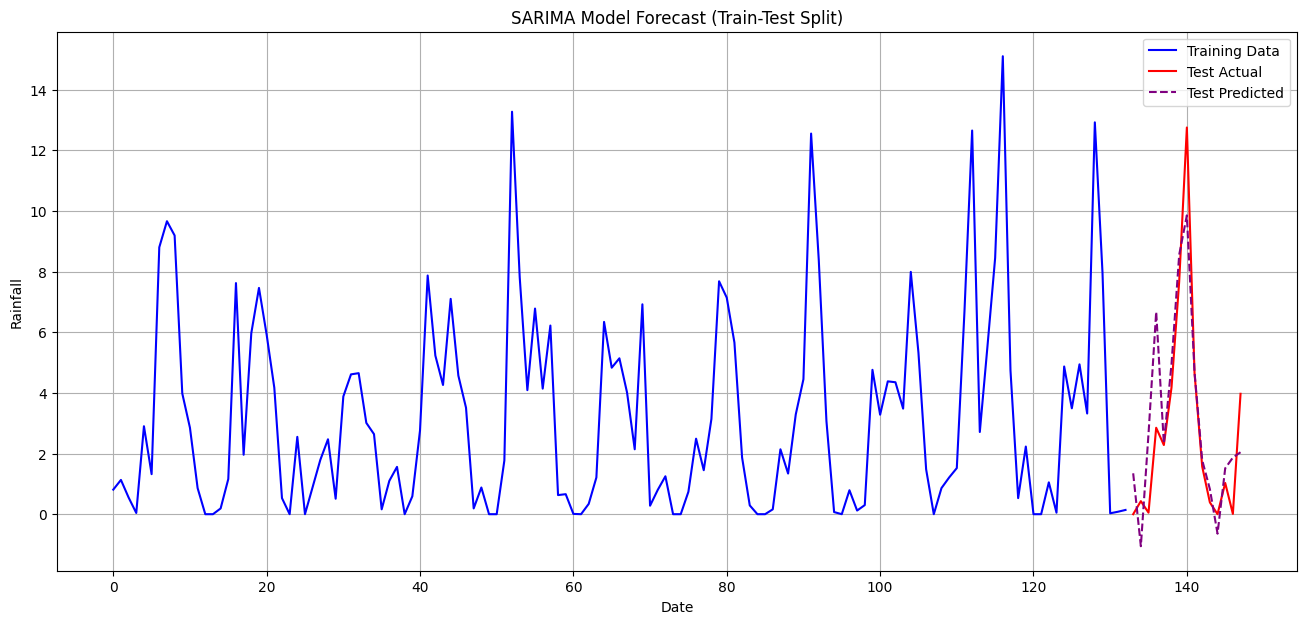

Test RMSE: 1.70
Test MAE: 1.30
Test SMAPE: 87.59%


In [ ]:
# prompt: พล็อตกราฟ Train Test และค่า Actual Predict มาให้ดูหน่อย และดูค่า RMSE MAE SMAPE

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

# Forecast the test set
# Determine the start and end indices for the forecast relative to the training data
# Get the index from the training data that was used in the model fitting
train_diff_index = train['y_diff1'].dropna().index

# Find the start position of the test set aligned with the training data index
# If the test set starts after the training data ends, use the length of the training data index
try:
   start_loc_test = train_diff_index.get_loc(test.index[0])
except KeyError:
    start_loc_test = len(train_diff_index)

# Set the end position for the test prediction
end_loc_test = start_loc_test + len(test) - 1

# Make predictions on the differenced series for the test set
test_pred_diff = model_x_fit.predict(start=start_loc_test, end=end_loc_test, dynamic=False)

# Align the differenced forecast index with the test index
test_pred_diff.index = test.index

# Inverse differencing to restore the original scale for test predictions
test_pred = []
# Use the last training value to start inverse differencing for the test set
last_train_y = train['ปริมาณน้ำฝน'].iloc[-1]

# The first test prediction is the last training value plus the first differenced prediction
if len(test_pred_diff) > 0:
    test_pred.append(last_train_y + test_pred_diff.iloc[0])
    # Iterate over the remaining differenced test predictions
    for i in range(1, len(test_pred_diff)):
        next_prediction = test_pred[-1] + test_pred_diff.iloc[i]
        test_pred.append(next_prediction)

# Convert the test predictions list to a Series with the proper index
test_pred = pd.Series(test_pred, index=test.index)

# Plot the results
plt.figure(figsize=(16, 7))
plt.plot(train.index, train['ปริมาณน้ำฝน'], label='Training Data', color='blue')
plt.plot(test.index, test['ปริมาณน้ำฝน'], label='Test Actual', color='red')
plt.plot(test.index, test_pred, label='Test Predicted', color='purple', linestyle='--')
plt.title('SARIMA Model Forecast (Train-Test Split)')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the test results
# Ensure no NaNs in actual or predicted values before calculating metrics
actual_test_cleaned = test['ปริมาณน้ำฝน'].dropna()
test_pred_cleaned = test_pred.dropna()

# Find common time points between actual and predicted data
common_index_test = actual_test_cleaned.index.intersection(test_pred_cleaned.index)

# Align the actual and predicted data using the common index
actual_test_aligned = actual_test_cleaned.loc[common_index_test]
test_pred_aligned = test_pred_cleaned.loc[common_index_test]

if not common_index_test.empty:
    # Calculate RMSE
    rmse_test = sqrt(mean_squared_error(actual_test_aligned, test_pred_aligned))
    print(f'Test RMSE: {rmse_test:.2f}')

    # Calculate MAE
    mae_test = mean_absolute_error(actual_test_aligned, test_pred_aligned)
    print(f'Test MAE: {mae_test:.2f}')

    # Calculate SMAPE
    # Avoid division by zero or very small numbers in SMAPE calculation
    smape_test = np.mean(2 * np.abs(test_pred_aligned - actual_test_aligned) / (np.abs(actual_test_aligned) + np.abs(test_pred_aligned) + 1e-8)) * 100
    print(f'Test SMAPE: {smape_test:.2f}%')

else:
    print("No common time points between actual and forecasted data for test evaluation.")

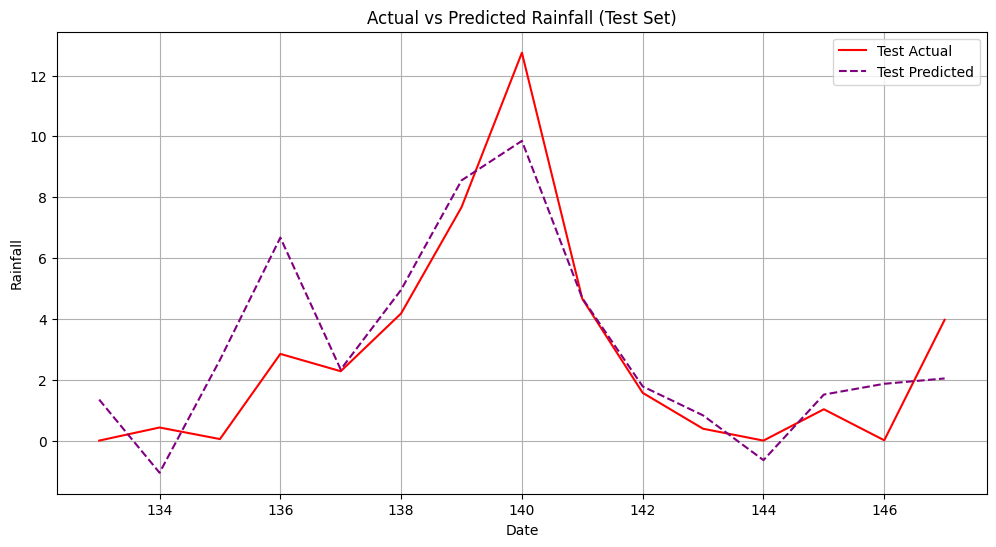

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot the actual vs predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['ปริมาณน้ำฝน'], label='Test Actual', color='red')
plt.plot(test.index, test_pred, label='Test Predicted', color='purple', linestyle='--')
plt.title('Actual vs Predicted Rainfall (Test Set)')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Calculate in-sample predictions for the training set
train_pred_diff = model_x_fit.predict(start=0, end=len(train['y_diff1'].dropna()) - 1, dynamic=False)

# Inverse differencing for training set predictions
train_pred = []
# The first training prediction is the first actual training value (since the first differenced value is NaN)
train_pred.append(train['ปริมาณน้ำฝน'].iloc[0])
# Iterate over the remaining differenced training predictions
for i in range(len(train_pred_diff)):
    next_prediction = train_pred[-1] + train_pred_diff.iloc[i]
    train_pred.append(next_prediction)

# Convert the training predictions list to a Series with the proper index
# The index should align with the original training data starting from the second element
train_pred = pd.Series(train_pred[1:], index=train.index[1:])


# Evaluate the training results
actual_train_cleaned = train['ปริมาณน้ำฝน'].iloc[1:].dropna() # Exclude the first value as its diff is NaN
train_pred_cleaned = train_pred.dropna()

common_index_train = actual_train_cleaned.index.intersection(train_pred_cleaned.index)

actual_train_aligned = actual_train_cleaned.loc[common_index_train]
train_pred_aligned = train_pred_cleaned.loc[common_index_train]


if not common_index_train.empty:
    # Calculate RMSE for training set
    rmse_train = sqrt(mean_squared_error(actual_train_aligned, train_pred_aligned))
    print(f'Training RMSE: {rmse_train:.2f}')

    # Calculate MAE for training set
    mae_train = mean_absolute_error(actual_train_aligned, train_pred_aligned)
    print(f'Training MAE: {mae_train:.2f}')
else:
    print("No common time points between actual and forecasted data for training evaluation.")

# Print Test set metrics (assuming they were calculated in a previous cell and variables exist)
# Need to ensure test_pred and test['ปริมาณน้ำฝน'] are accessible and aligned
if 'rmse_test' in globals() and 'mae_test' in globals():
    print(f'Test RMSE: {rmse_test:.2f}')
    print(f'Test MAE: {mae_test:.2f}')
else:
    print("Test set metrics (RMSE, MAE) not found. Please ensure the cell calculating them has been run.")

Training RMSE: 10.11
Training MAE: 7.69
Test RMSE: 1.70
Test MAE: 1.30


In [ ]:
mask = actual_test_aligned > 1
smape_filtered = np.mean(
    2 * np.abs(test_pred_aligned[mask] - actual_test_aligned[mask]) /
    (np.abs(actual_test_aligned[mask]) + np.abs(test_pred_aligned[mask]) + 1e-8)
) * 100
print(f'Filtered SMAPE (actual > 1): {smape_filtered:.2f}%')


Filtered SMAPE (actual > 1): 27.94%
